In [1]:
import sys
# setting path
sys.path.append('../')

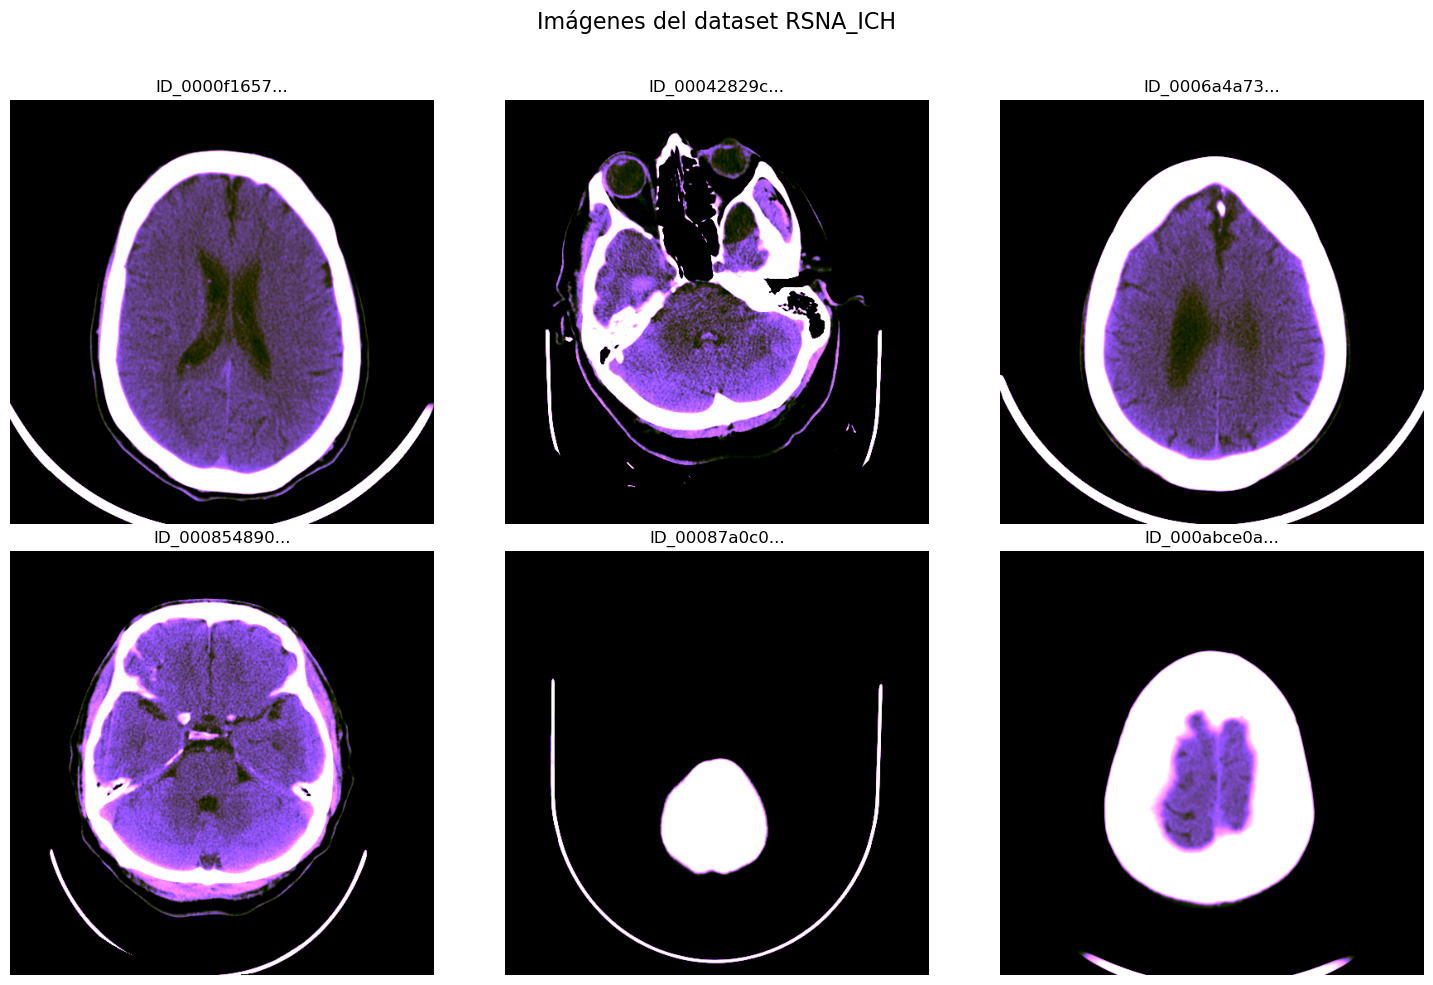

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Ruta absoluta al directorio de las imágenes
NPY_DIR = "/data/datasets/RSNA_ICH/original/"

# Listar los primeros 6 archivos .npy del directorio que comiencen por "ID_"
try:
    all_files = os.listdir(NPY_DIR)
except FileNotFoundError:
    print(f"ERROR: No se pudo encontrar el directorio en la ruta especificada.")
    print(f"Ruta intentada: {os.path.abspath(NPY_DIR)}")
    all_files = []

npy_files = sorted([f for f in all_files if f.startswith("ID_") and f.endswith(".npy")])[:6]

# Asegurarse de que hay al menos 6 archivos
if len(npy_files) < 6:
    print(f"Advertencia: Se encontraron solo {len(npy_files)} archivos de los 6 solicitados.")
    print("Se mostrarán los que se hayan encontrado.")

if npy_files:
    # Un aspect ratio más cuadrado (ej. 15 de ancho por 10 de alto) funciona mejor
    plt.figure(figsize=(15, 10))

    # Recorrer los archivos y mostrarlos
    for i, filename in enumerate(npy_files):
        img_path = os.path.join(NPY_DIR, filename)
        img_array = np.load(img_path)
        
        # --- CAMBIO 3: CREAR UNA CUADRÍCULA DE 2 FILAS Y 3 COLUMNAS ---
        # plt.subplot(filas, columnas, índice)
        plt.subplot(2, 3, i + 1)
        
        plt.imshow(img_array, cmap='gray')
        plt.axis('off')
        plt.title(filename[:12] + "...")

    # Título general de la figura
    plt.suptitle("Imágenes del dataset RSNA_ICH", fontsize=16)

    # --- CAMBIO 4: OPTIMIZAR EL ESPACIO EN BLANCO ---
    # tight_layout() ajusta automáticamente los subplots para que no haya solapamientos
    # y se reduzca el espacio en blanco.
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # El rect ajusta el espacio para el suptitle

    # Mostrar la figura
    plt.show()
else:
    print("No se encontraron imágenes para mostrar.")

/tmp/ipykernel_59888/2201795794.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


Modelo cargado desde: models/rsna/attention/seed0/model.pth
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Bag ID para índice 10: ID_fe18e73b79

Visualizando bolsa: ID_fe18e73b79
Predicción: 0.7480
Etiqueta real: 1.0


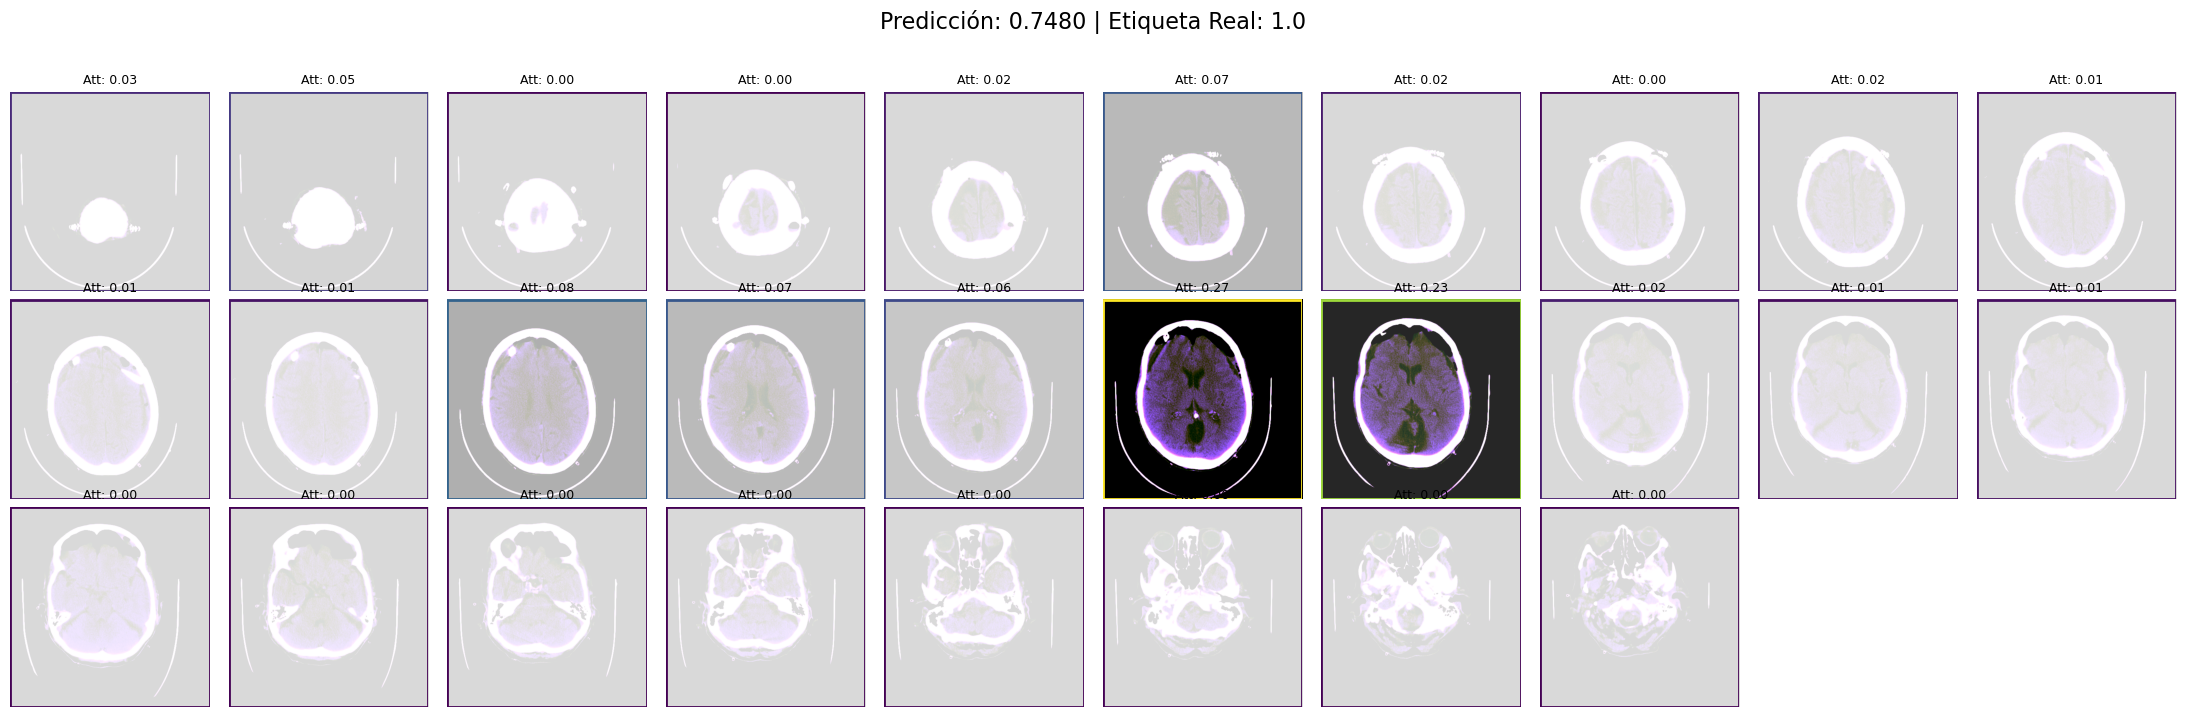


Proceso de visualización completado.


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path
from argparse import Namespace

# --- CONFIGURACIÓN DE RUTAS E IMPORTACIONES ---
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

try:
    from scripts.dataset_loader import load_dataset
    from scripts.MIL_utils import MIL_collate_fn
    from scripts.model import MILModel
    from scripts.plot_utils import normalize 
except (ImportError, ModuleNotFoundError) as e:
    print(f"Error importando módulos: {e}")
    print("Asegúrate de que la estructura de tu proyecto y el `sys.path` son correctos.")
    sys.exit()

# --- Función de Ploteo Personalizada para Slices de CT con Alpha ---
def plot_ct_slices_and_heatmap(patches, attention_scores_normalized, attention_scores_raw, bag_id, pred_prob, true_label, num_cols=10, min_alpha=0.15):
    """
    Visualiza todas las slices de CT de una bolsa.
    Usa los pesos de atención NORMALIZADOS para la transparencia y borde,
    y los pesos de atención CRUDOS para el texto en el título del subplot.
    """
    if len(patches) != len(attention_scores_normalized) or len(patches) != len(attention_scores_raw):
        print("Advertencia: El número de parches, pesos de atención normalizados o crudos no coincide. Ajustando al menor número.")
        min_len = min(len(patches), len(attention_scores_normalized), len(attention_scores_raw))
        patches = patches[:min_len]
        attention_scores_normalized = attention_scores_normalized[:min_len]
        attention_scores_raw = attention_scores_raw[:min_len]
        if min_len == 0:
            print("No hay parches o scores para visualizar.")
            return

    num_patches = len(patches)
    num_rows = (num_patches + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2.2, num_rows * 2.5))
    axes = axes.flatten()
    
    # Título de la figura reducido como solicitado
    fig.suptitle(f"Predicción: {pred_prob:.4f} | Etiqueta Real: {true_label}", fontsize=16)

    for i in range(num_patches):
        if i >= len(axes): 
            break
        
        ax = axes[i]
        current_patch = patches[i]
        current_attention_normalized = attention_scores_normalized[i] 
        current_attention_raw = attention_scores_raw[i] 

        display_alpha = max(current_attention_normalized, min_alpha)
        
        if current_patch.ndim == 3 and current_patch.shape[-1] == 3:
            ax.imshow(current_patch, alpha=display_alpha) 
        elif current_patch.ndim == 2:
            ax.imshow(current_patch, cmap='gray', alpha=display_alpha)
        elif current_patch.ndim == 3 and current_patch.shape[-1] == 1:
             ax.imshow(current_patch.squeeze(axis=-1), cmap='gray', alpha=display_alpha)
        else:
            ax.set_title(f"Inválido\nAtt: {current_attention_raw:.2f}", fontsize=8)
            ax.axis('off')
            continue

        # Usar la atención RAW para el título del subplot
        ax.set_title(f"Att: {current_attention_raw:.2f}", fontsize=9, 
                     color='red' if current_attention_raw > 0.7 else ('orange' if current_attention_raw > 0.4 else 'black'))
        ax.axis('off')

        rect = plt.Rectangle((0, 0), current_patch.shape[1]-1, current_patch.shape[0]-1, 
                             linewidth=2, edgecolor=plt.cm.viridis(current_attention_normalized), facecolor='none', alpha=1.0)
        ax.add_patch(rect)

    for i in range(num_patches, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- FIN DE LA FUNCIÓN DE PLOTEO CUSTOM ---


# --- PARÁMETROS DE VISUALIZACIÓN ---
MODEL_PATH = "models/rsna/attention/seed0/model.pth" 
ORIGINAL_DATA_DIR = "/data/datasets/RSNA_ICH/original/" # No se usa directamente aquí, pero es buen info
BAG_INDEX_TO_VISUALIZE = 10 

config_dict = {
    "dataset_name": "rsna", 
    "val_prop": 0.15,
    "seed": 0, 
    "use_inst_distances": False,
    "adj_mat_mode": "relative"
}
config = Namespace(**config_dict)

INPUT_FEATURE_DIM = 512 
FEATURE_DIM = 128

# --- 1. CARGAR MODELO Y DATASET ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MILModel(
    pooling_type='attention',
    input_feature_dim=INPUT_FEATURE_DIM,
    feature_dim=FEATURE_DIM
)

try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.to(device)
    model.eval()
    print(f"Modelo cargado desde: {MODEL_PATH}")
except FileNotFoundError:
    print(f"ERROR: No se encontró el modelo en: {MODEL_PATH}")
    sys.exit()
except Exception as e:
    print(f"ERROR al cargar el modelo: {e}")
    sys.exit()

# --- CARGA DE DATASETS SEPARADOS PARA FEATURES Y IMÁGENES ---
config_features = Namespace(**{
    "dataset_name": "rsna-features_resnet18", 
    "val_prop": 0.15, "seed": config.seed, "use_inst_distances": False, "adj_mat_mode": "relative"
})
test_dataset_features = load_dataset(config=config_features, mode="test")

config_images = Namespace(**{
    "dataset_name": "rsna", 
    "val_prop": 0.15, "seed": config.seed, "use_inst_distances": False, "adj_mat_mode": "relative"
})
test_dataset_images = load_dataset(config=config_images, mode="test")

if BAG_INDEX_TO_VISUALIZE >= len(test_dataset_features) or BAG_INDEX_TO_VISUALIZE >= len(test_dataset_images):
    print(f"Error: BAG_INDEX_TO_VISUALIZE ({BAG_INDEX_TO_VISUALIZE}) fuera de rango.")
    sys.exit()

sample_features = test_dataset_features[BAG_INDEX_TO_VISUALIZE]
bag_features_for_model = sample_features[0] 
bag_label = sample_features[1] 

try:
    bag_id = test_dataset_images.bag_names[BAG_INDEX_TO_VISUALIZE]
    print(f"Bag ID para índice {BAG_INDEX_TO_VISUALIZE}: {bag_id}")
except AttributeError:
    print("Error: 'bag_names' no encontrado en el dataset de IMÁGENES.")
    sys.exit()
except IndexError:
    print(f"Error: Índice {BAG_INDEX_TO_VISUALIZE} fuera de rango para 'bag_names'.")
    sys.exit()

instance_paths_for_images = []
try:
    if hasattr(test_dataset_images, 'data_dict') and bag_id in test_dataset_images.data_dict:
        instance_paths_for_images = test_dataset_images.data_dict[bag_id]['inst_paths']
    else:
        raise AttributeError("El dataset de IMÁGENES no tiene 'data_dict' o 'bag_id' inválido.")
except (AttributeError, KeyError) as e:
    print(f"Error al obtener rutas de IMÁGENES para '{bag_id}': {e}")
    sys.exit()


# --- 2. OBTENER PESOS DE ATENCIÓN (USANDO FEATURES) ---
with torch.no_grad():
    bag_tensor = bag_features_for_model.unsqueeze(0).to(device) 
    prediction, attention_weights_raw = model(bag_tensor)
    attention_weights_raw = attention_weights_raw.squeeze(0).cpu().numpy()
    prediction_prob = torch.sigmoid(prediction).item()

# NORMALIZAR LOS PESOS DE ATENCIÓN
normalized_attention = normalize(attention_weights_raw) 


# --- 3. CARGAR IMÁGENES ORIGINALES DE LOS PARCHES (PARA VISUALIZACIÓN) ---
patches_image_data = [] 
if instance_paths_for_images: 
    for p_path in instance_paths_for_images:
        full_path = p_path 
        
        if os.path.exists(full_path):
            try:
                img_data = np.load(full_path)
                
                if img_data.ndim == 2 or (img_data.ndim == 3 and img_data.shape[-1] in [3, 4]):
                    patches_image_data.append(img_data)
                elif img_data.ndim == 3 and img_data.shape[-1] == 1:
                    patches_image_data.append(img_data.squeeze(axis=-1))
                # No necesitamos el else aquí, el error ya se maneja en el plotter
            except Exception as e:
                print(f"Advertencia: Error al cargar/procesar {full_path}: {e}")
        else:
            print(f"Advertencia: Parche de imagen no encontrado: {full_path}")

if not patches_image_data:
    print("Error: No se pudieron cargar parches para la visualización. Verifica rutas.")
    sys.exit()
else:
    # --- 4. VISUALIZACIÓN ---
    print(f"\nVisualizando bolsa: {bag_id}")
    print(f"Predicción: {prediction_prob:.4f}")
    print(f"Etiqueta real: {bag_label.item()}") 

    plot_ct_slices_and_heatmap(
        patches=patches_image_data, 
        attention_scores_normalized=normalized_attention,
        attention_scores_raw=attention_weights_raw,       
        bag_id=bag_id, # Se sigue pasando para el nombre del archivo si se guarda, aunque no en el título del plot
        pred_prob=prediction_prob,
        true_label=bag_label.item()
    )

print("\nProceso de visualización completado.")